# Spark - Ejercicio introducción aprendizaje supervisado
## TDM - Máster en IoT - Por Pablo C. Cañizares

In [14]:
import findspark

findspark.init()

import pyspark  # only run after findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

df = spark.sql("""select 'spark' as hola """)
df.show()

+-----+
| hola|
+-----+
|spark|
+-----+



In [15]:
# Paso 1: Importar las bibliotecas necesarias
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt

# Paso 2: Crear una sesión de Spark
spark = SparkSession.builder.appName("LinearRegressionExample").getOrCreate()

# Paso 3: Cargar el dataset directamente con Spark
file_path = "RT_IOT2022.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Mostrar el esquema de los datos
df.printSchema()

# Mostrar las primeras filas del dataset
df.show(5)

root
 |-- no: integer (nullable = true)
 |-- id.orig_p: integer (nullable = true)
 |-- id.resp_p: integer (nullable = true)
 |-- proto: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flow_duration: double (nullable = true)
 |-- fwd_pkts_tot: integer (nullable = true)
 |-- bwd_pkts_tot: integer (nullable = true)
 |-- fwd_data_pkts_tot: integer (nullable = true)
 |-- bwd_data_pkts_tot: integer (nullable = true)
 |-- fwd_pkts_per_sec: double (nullable = true)
 |-- bwd_pkts_per_sec: double (nullable = true)
 |-- flow_pkts_per_sec: double (nullable = true)
 |-- down_up_ratio: double (nullable = true)
 |-- fwd_header_size_tot: integer (nullable = true)
 |-- fwd_header_size_min: integer (nullable = true)
 |-- fwd_header_size_max: integer (nullable = true)
 |-- bwd_header_size_tot: integer (nullable = true)
 |-- bwd_header_size_min: integer (nullable = true)
 |-- bwd_header_size_max: integer (nullable = true)
 |-- flow_FIN_flag_count: integer (nullable = true)
 |-- flow_S

In [16]:
# Analizamos que no tengamos nulos y valores raros en  el vector assembler
df.select("flow_duration").distinct().show()
df.select("fwd_pkts_tot").distinct().show()

+--------------------+
|       flow_duration|
+--------------------+
|           31.851752|
|           32.001236|
|           32.031655|
|           16.930018|
|           48.964688|
|            3.982985|
|            15.92439|
|           37.939388|
|  32.064640000000004|
|           58.959957|
|           58.035451|
|           12.907548|
|            61.97268|
|           61.970911|
|   61.99616999999999|
|           61.966472|
|0.049625999999999997|
|            0.262941|
|            0.743375|
|            0.036315|
+--------------------+
only showing top 20 rows

+------------+
|fwd_pkts_tot|
+------------+
|          31|
|          81|
|          28|
|          26|
|          12|
|          22|
|           1|
|          13|
|           6|
|          16|
|           3|
|          40|
|          20|
|           5|
|          19|
|          92|
|          64|
|          15|
|          88|
|           9|
+------------+
only showing top 20 rows



In [17]:
# Paso 4: Preparar los datos para la regresión lineal
# Asumimos que la columna 'flow_duration' es la variable independiente y 'fwd_pkts_tot' es la variable dependiente.

# Seleccionamos las columnas necesarias
df = df.select("flow_duration", "fwd_pkts_tot")

# Revisar el tamaño del dataset después de cada paso
print(f"Registros antes del filtrado: {df.count()}")

# Dropeamos nulos
df.na.drop()
df = df.filter(df.flow_duration.isNotNull())
df = df.filter(df.fwd_pkts_tot.isNotNull())
df.select("flow_duration").distinct().show()
# df = df.dropDuplicates()

# Revisar el tamaño del dataset después de cada paso
print(f"Registros despues del filtrado: {df.count()}")

# Convertimos 'flow_duration' en un vector que puede usar Spark ML
assembler = VectorAssembler(inputCols=["flow_duration"], outputCol="features")
df = assembler.transform(df)

# Mostrar el dataframe transformado
df.show(5)

Registros antes del filtrado: 123117
+--------------------+
|       flow_duration|
+--------------------+
|           31.851752|
|           32.001236|
|           32.031655|
|           16.930018|
|           48.964688|
|            3.982985|
|            15.92439|
|           37.939388|
|  32.064640000000004|
|           58.959957|
|           58.035451|
|           12.907548|
|            61.97268|
|           61.970911|
|   61.99616999999999|
|           61.966472|
|0.049625999999999997|
|            0.262941|
|            0.743375|
|            0.036315|
+--------------------+
only showing top 20 rows

Registros despues del filtrado: 123117
+------------------+------------+--------------------+
|     flow_duration|fwd_pkts_tot|            features|
+------------------+------------+--------------------+
|         32.011598|           9|         [32.011598]|
|31.883584000000006|           9|[31.883584000000006]|
|         32.124053|           9|         [32.124053]|
|         31.961

In [18]:
# Paso 5: Dividir los datos en entrenamiento (80%) y prueba (20%)
train_data, test_data = df.randomSplit([0.6, 0.4], seed=1234)

In [19]:
# Paso 6: Crear y entrenar el modelo de regresión lineal
lr = LinearRegression(featuresCol="features", labelCol="fwd_pkts_tot", regParam=0.1)
lr_model = lr.fit(train_data)

# Imprimir los coeficientes y el intercept
# Coeficiente: la influencia que cada variable independiente (predictora) tiene sobre la variable dependiente (objetivo).
# > 0 : A medida que la variable predictora aumenta, la variable dependiente también tiende a aumentar.
# < 0 : A medida que la variable predictora disminuye, la variable dependiente también tiende a disminuir.
# = 0 : La variable predictora tiene poco o ningún impacto en la variable dependiente.
print(f"Coeficiente: {lr_model.coefficients}")

# Intercept: Valor de la variable dependiente cuando todas las variables predictoras son iguales a cero.
# Interpretación del intercept (23500): El salario inicial predicho para alguien con cero años de experiencia es 23,500 dólares.
# Esto significa que, según el modelo, alguien sin experiencia aún podría esperar ganar 30,000 dólares.
print(f"Intercept: {lr_model.intercept}")

Coeficiente: [0.13808211345206162]
Intercept: 1.7358677884391691


In [20]:
# Paso 7: Realizar predicciones sobre los datos de prueba
predictions = lr_model.transform(test_data)

# Mostrar las predicciones junto con los valores reales
predictions.select("flow_duration", "fwd_pkts_tot", "prediction").show()

+-------------+------------+------------------+
|flow_duration|fwd_pkts_tot|        prediction|
+-------------+------------+------------------+
|          0.0|           0|1.7358677884391691|
|          0.0|           0|1.7358677884391691|
|          0.0|           0|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884

In [21]:
# Paso 8: Evaluar el modelo utilizando RMSE y R2
# *Root Mean Squared Error (RMSE): Evaluar la precisión de un modelo de predicción
# -Mide la discrepancia promedio entre los valores predichos por el modelo y los valores reales de los datos.
# -Cuanto menor sea el valor del RMSE, mejor será el ajuste del modelo a los datos.
evaluator = RegressionEvaluator(
    labelCol="fwd_pkts_tot", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator.evaluate(predictions)
print(f"Error cuadrático medio (RMSE): {rmse}")

# R-Squared:  Analiza como se ajustan los valores predichos por el modelo a los valores reales de la variable dependiente.
# R2=1: Ajuste perfecto; el modelo explica el 100% de la variabilidad en la variable dependiente.
r2_evaluator = RegressionEvaluator(
    labelCol="fwd_pkts_tot", predictionCol="prediction", metricName="r2"
)
r2 = r2_evaluator.evaluate(predictions)
print(f"R2: {r2}")

Error cuadrático medio (RMSE): 16.783552659770113
R2: 0.3247751505179488


+-------------+------------+------------------+
|flow_duration|fwd_pkts_tot|        prediction|
+-------------+------------+------------------+
|          0.0|           0|1.7358677884391691|
|          0.0|           0|1.7358677884391691|
|          0.0|           0|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884391691|
|          0.0|           1|1.7358677884

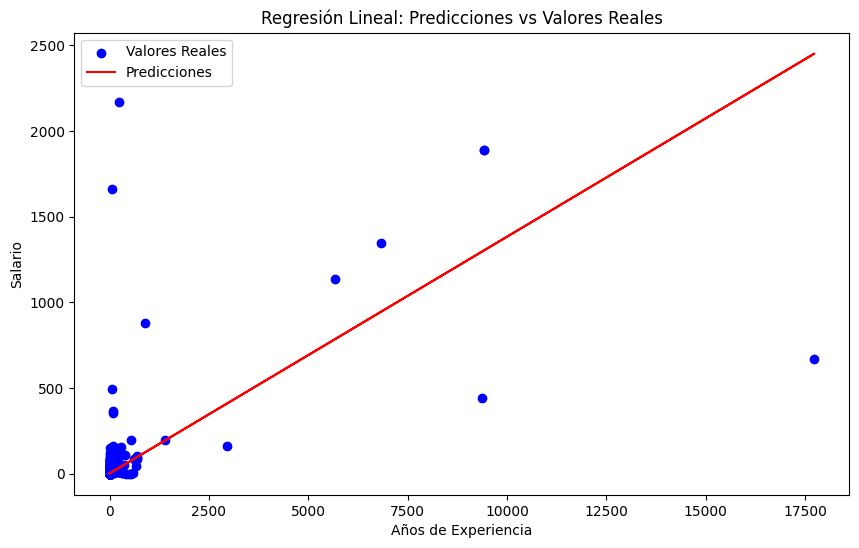

In [22]:
# Paso 9: Visualizar los resultados con una gráfica comparativa
# Convertimos los datos de predicciones a un formato local (para usar en matplotlib)
preds_pd = predictions.select("flow_duration", "fwd_pkts_tot", "prediction").toPandas()

# Mostrar las predicciones y los valores reales
predictions.select("flow_duration", "fwd_pkts_tot", "prediction").show()

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(
    preds_pd["flow_duration"],
    preds_pd["fwd_pkts_tot"],
    color="blue",
    label="Valores Reales",
)
plt.plot(
    preds_pd["flow_duration"],
    preds_pd["prediction"],
    color="red",
    label="Predicciones",
)
plt.xlabel("Años de Experiencia")
plt.ylabel("Salario")
plt.title("Regresión Lineal: Predicciones vs Valores Reales")
plt.legend()
plt.show()

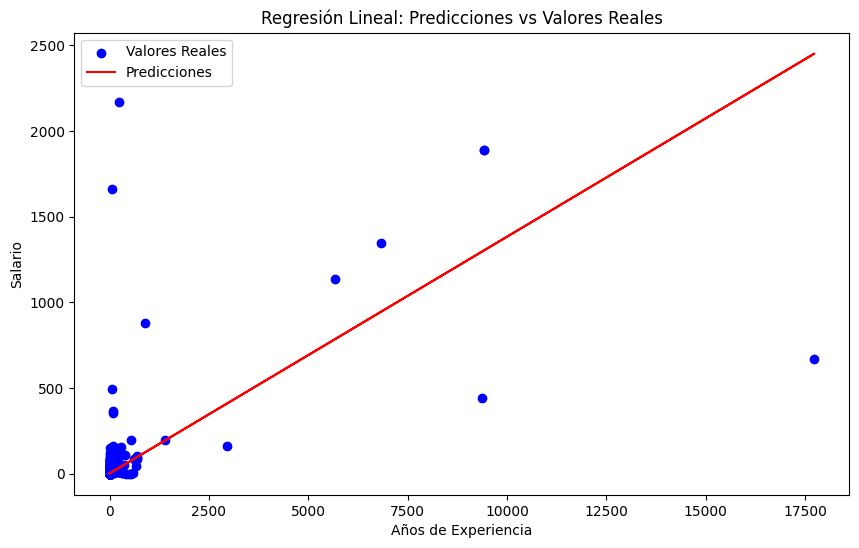

In [23]:
# Paso 9 (sin Pandas): Visualizar los resultados con una gráfica comparativa
# Convertimos los datos de predicciones a un formato local (para usar en matplotlib)
import matplotlib.pyplot as plt

# Paso 1: Extraer los datos de predicción del DataFrame de PySpark
# Convertimos los resultados a listas de Python
years_experience = [
    row["flow_duration"] for row in predictions.select("flow_duration").collect()
]
fwd_pkts_tot_real = [
    row["fwd_pkts_tot"] for row in predictions.select("fwd_pkts_tot").collect()
]
fwd_pkts_tot_predicted = [
    row["prediction"] for row in predictions.select("prediction").collect()
]

# Paso 2: Graficar los resultados
plt.figure(figsize=(10, 6))

# Puntos de los valores reales (azul)
plt.scatter(years_experience, fwd_pkts_tot_real, color="blue", label="Valores Reales")

# Línea de las predicciones (rojo)
plt.plot(years_experience, fwd_pkts_tot_predicted, color="red", label="Predicciones")

# Configuración de la gráfica
plt.xlabel("Años de Experiencia")
plt.ylabel("Salario")
plt.title("Regresión Lineal: Predicciones vs Valores Reales")
plt.legend()
plt.show()

In [24]:
# Paso 10: Predecir el salario para un valor específico de 'flow_duration'

# Creamos un dataframe con el valor que queremos predecir (por ejemplo, 5 años de experiencia)
df_prediction = spark.createDataFrame([(5.0,)], ["flow_duration"])

# Convertimos 'flow_duration' en un vector para que sea compatible con el modelo
df_prediction = assembler.transform(df_prediction)

# Realizamos la predicción
predicted_fwd_pkts_tot = lr_model.transform(df_prediction)

# Mostramos la predicción
predicted_fwd_pkts_tot.select("flow_duration", "prediction").show()

+-------------+-----------------+
|flow_duration|       prediction|
+-------------+-----------------+
|          5.0|2.426278355699477|
+-------------+-----------------+



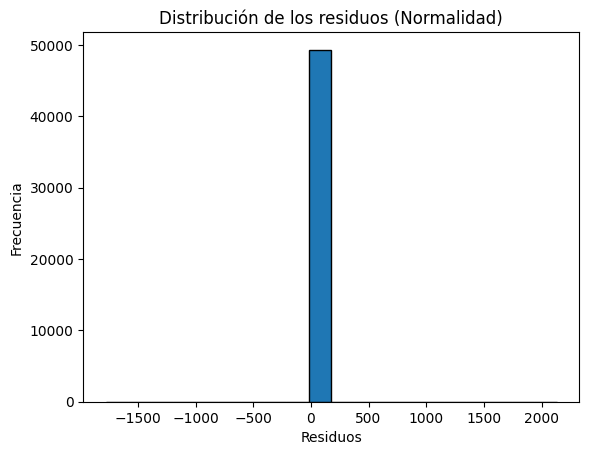

In [25]:
# Normalidad
# Calcular los residuos (fwd_pkts_tot - Predicción)
residuals = predictions.withColumn(
    "residuals", predictions["fwd_pkts_tot"] - predictions["prediction"]
)

# Recoger los valores de los residuos
residuals_values = [row["residuals"] for row in residuals.select("residuals").collect()]

# Gráfico de histograma de los residuos
plt.hist(residuals_values, bins=20, edgecolor="black")
plt.title("Distribución de los residuos (Normalidad)")
plt.xlabel("Residuos")
plt.ylabel("Frecuencia")
plt.show()

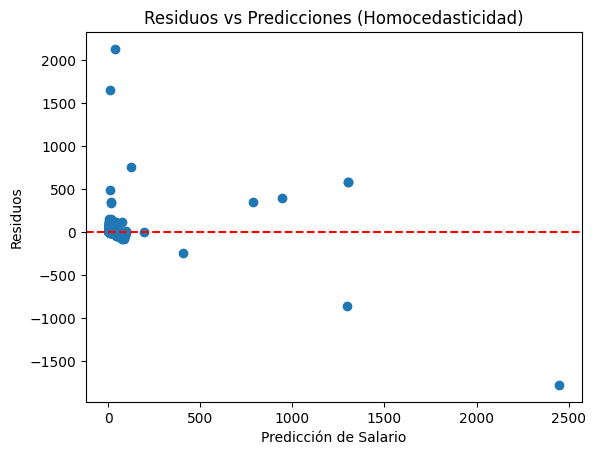

In [26]:
# Homodecasticidad
# Recoger los valores de Predicciones y Residuos para el gráfico
predicted_values = [
    row["prediction"] for row in predictions.select("prediction").collect()
]
residuals_values = [row["residuals"] for row in residuals.select("residuals").collect()]

# Gráfico de Residuos vs Predicciones
plt.scatter(predicted_values, residuals_values)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicción de Salario")
plt.ylabel("Residuos")
plt.title("Residuos vs Predicciones (Homocedasticidad)")
plt.show()

In [27]:
# Sesgo
# Calcular el sesgo (promedio de los residuos)
sesgo = sum(residuals_values) / len(residuals_values)
print(f"Sesgo: {sesgo}")

Sesgo: 0.01728026715648572


In [28]:
# Varianza
# Calcular la media de los residuos
residuals_mean = sum(residuals_values) / len(residuals_values)

# Calcular la varianza de los residuos
varianza = sum((residuo - residuals_mean) ** 2 for residuo in residuals_values) / len(
    residuals_values
)
print(f"Varianza: {varianza}")

Varianza: 281.6873412756434


## Hemos analizado los gráficos, ahora pasemos los tests necesarios

| Propiedad            | Método gráfico             | Test estadístico               | Resultado esperado             |
|----------------------|----------------------------|---------------------------------|--------------------------------|
| **Linealidad**        | Predicciones vs. X         | **Test de Ramsey RESET**        | Relación lineal                |
| **Normalidad**        | Histograma de residuos     | **Shapiro-Wilk / K-S Test**     | p > 0.05 (normalidad)          |
| **Homocedasticidad**  | Residuos vs Predicciones   | **Breusch-Pagan**               | p > 0.05 (varianza constante)  |
| **Independencia**     | Ninguno                    | **Durbin-Watson**               | DW ≈ 2 (sin autocorrelación)   |
| **Sesgo**             | Ninguno                    | Promedio de residuos            | Sesgo ≈ 0                      |
| **Varianza**          | Ninguno                    | Cálculo de varianza             | Varianza baja                  |


In [29]:
# Linealidad
# Ajustar el modelo
from statsmodels.stats.diagnostic import linear_reset
import statsmodels.api as sm

X = years_experience
y = fwd_pkts_tot_real

model = sm.OLS(y, X)
results = model.fit()

reset_test = linear_reset(results)
print(reset_test)

<Wald test (chi2): statistic=12851.911302759263, p-value=0.0, df_denom=2>


In [30]:
# Normalidad
from scipy import stats

# Test de normalidad de Shapiro-Wilk
shapiro_test = stats.shapiro(residuals_values)
print(f"Shapiro-Wilk Test: {shapiro_test}")

Shapiro-Wilk Test: ShapiroResult(statistic=np.float64(0.020337786985483608), pvalue=np.float64(1.0555763508793762e-162))


/home/josugoar/miniconda3/envs/tdm/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 49338.
  res = hypotest_fun_out(*samples, **kwds)


In [31]:
# Homocedasticidad
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Ajustar un modelo de regresión (X son las variables predictoras, y la variable dependiente)
X = sm.add_constant(X)  # Agregar una constante al modelo
modelo = sm.OLS(y, X).fit()

# Realizar el test de Breusch-Pagan
test_bp = het_breuschpagan(modelo.resid, modelo.model.exog)

# Resultados del test
print(f"Estadístico LM: {test_bp[0]}")
print(
    f"p-valor: {test_bp[1]}"
)  # Este es el p-valor clave para interpretar homoscedasticidad
print(f"Estadístico F: {test_bp[2]}")
print(f"p-valor F: {test_bp[3]}")

Estadístico LM: 5367.325519397452
p-valor: 0.0
Estadístico F: 6022.249486798505
p-valor F: 0.0


In [32]:
# Independencia
from statsmodels.stats.stattools import durbin_watson

# Calcular el estadístico de Durbin-Watson
dw_test = durbin_watson(residuals_values)
print(f"Durbin-Watson: {dw_test}")

Durbin-Watson: 2.1620611309425137


## 